# Loading models

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DeepLabV3_EfficientNet_ImageNet.pt to DeepLabV3_EfficientNet_ImageNet (1).pt


In [ ]:
!pip install segmentation-models-pytorch

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights

# DoubleConv для FCN8_Pretrained_Improved
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Клас FCN8_Pretrained_Improved
class FCN8_Pretrained_Improved(nn.Module):
    def __init__(self,
                 input_shape=(3, 256, 256),
                 num_classes=24,
                 num_conv_filters=1024):
        super(FCN8_Pretrained_Improved, self).__init__()

        self.num_classes = num_classes
        self.num_conv_filters = num_conv_filters

        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.features = vgg.features

        self.fc6 = DoubleConv(512, 756)
        self.drop6 = nn.Dropout(0.5)

        self.fc7 = DoubleConv(756, num_conv_filters)
        self.drop7 = nn.Dropout(0.5)

        self.fc8 = DoubleConv(num_conv_filters, 512)
        self.drop8 = nn.Dropout(0.5)

        self.score_fr = nn.Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))

        self.upscore2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.score_pool4 = DoubleConv(512, 64)
        self.upscore_pool4 = nn.ConvTranspose2d(64, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.score_pool3 = DoubleConv(256, num_classes)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)

    def forward(self, x):
        pool3 = None
        pool4 = None

        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:
                pool3 = x
            if i == 23:
                pool4 = x
        pool5 = x

        x = self.fc6(pool5)
        x = self.drop6(x)

        x = self.fc7(x)
        x = self.drop7(x)

        x = self.fc8(x)
        x = self.drop8(x)

        x = self.score_fr(x)

        x = self.upscore2(x)
        pool4_score = self.score_pool4(pool4)
        x = x + pool4_score

        x = self.upscore_pool4(x)
        pool3_score = self.score_pool3(pool3)
        x = x + pool3_score

        x = self.upscore8(x)

        return x


In [3]:
import torch
import torchvision.models as models

fcn_model = torch.load('.\models\FCN8_VGG16_ImageNet.pt')

fcn_model.eval()

C:\Users\Anna\AppData\Local\Temp\ipykernel_14116\893162932.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fcn_model = torch.load('.\models\FCN8_VGG16_ImageNet.pt')


FCN8_Pretrained_Improved(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [9]:
import torch
import torchvision.models as models

deep_lab_model = torch.load('./models/DeepLabV3_EfficientNet_ImageNet.pt')

deep_lab_model.eval()

C:\Users\Anna\AppData\Local\Temp\ipykernel_26024\1832459666.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_lab_model = torch.load('./models/DeepLabV3_EfficientNet_

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

In [ ]:
import torch
import torchvision.models as models

fcn_model = torch.load('FCN8_VGG16_ImageNet.pt')

fcn_model.eval()

<ipython-input-31-f4c15543f700>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fcn_model = torch.load('FCN8_VGG16_ImageNet.pt')


FCN8_Pretrained_Improved(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [ ]:
import torch
import torchvision.models as models

deep_lab_model = torch.load('DeepLabV3_EfficientNet_ImageNet.pt')

deep_lab_model.eval()

<ipython-input-5-9d5df68f7676>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_lab_model = torch.load('DeepLabV3_EfficientNet_ImageNet.pt')


DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

# Loading data

In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

!unzip semantic-drone-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
semantic-drone-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  semantic-drone-dataset.zip
replace RGB_color_image_masks/RGB_color_image_masks/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_m

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

import segmentation_models_pytorch as smp

In [3]:
data_path = ''
imgs_path = os.path.join(data_path, 'dataset/semantic_drone_dataset/original_images')
masks_path = os.path.join(data_path, 'RGB_color_image_masks', 'RGB_color_image_masks')

n_classes = 24
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


def create_df():
    name = []
    for dirname, _, filenames in os.walk(imgs_path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

cpu
Total Images:  400


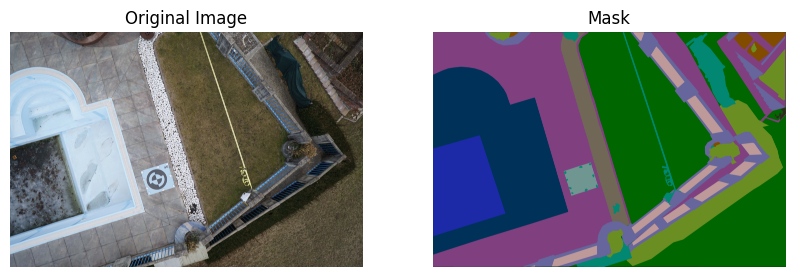

In [4]:
image_name = os.listdir(imgs_path)[35]
org_img = cv2.imread(os.path.join(imgs_path, image_name))
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(masks_path, image_name.replace('.jpg', '.png')))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(org_img)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')
plt.show()

In [5]:
X_train, X_val = train_test_split(df['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  340
Val Size     :  60


In [6]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, self.X[idx] + '.jpg')
        mask_path = os.path.join(self.mask_path, self.X[idx] + '.png')

        # Check if files exist
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Read images
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to read mask: {mask_path}")

        # Apply transformations
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask


In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
#                      A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
#                      A.GaussNoise()])

# t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
#                    A.GridDistortion(p=0.2)])


t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = DroneDataset(imgs_path, masks_path, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(imgs_path, masks_path, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Grad-CAM (Class Activation Mapping)

Призначення: Візуалізація того, які області зображення впливають на передбачення моделі.

Ми застосуємо Grad-CAM, щоб побудувати теплові карти для зображень із валідаційного набору даних.
Це допоможе зрозуміти, які регіони моделі вважають важливими для передбачення.

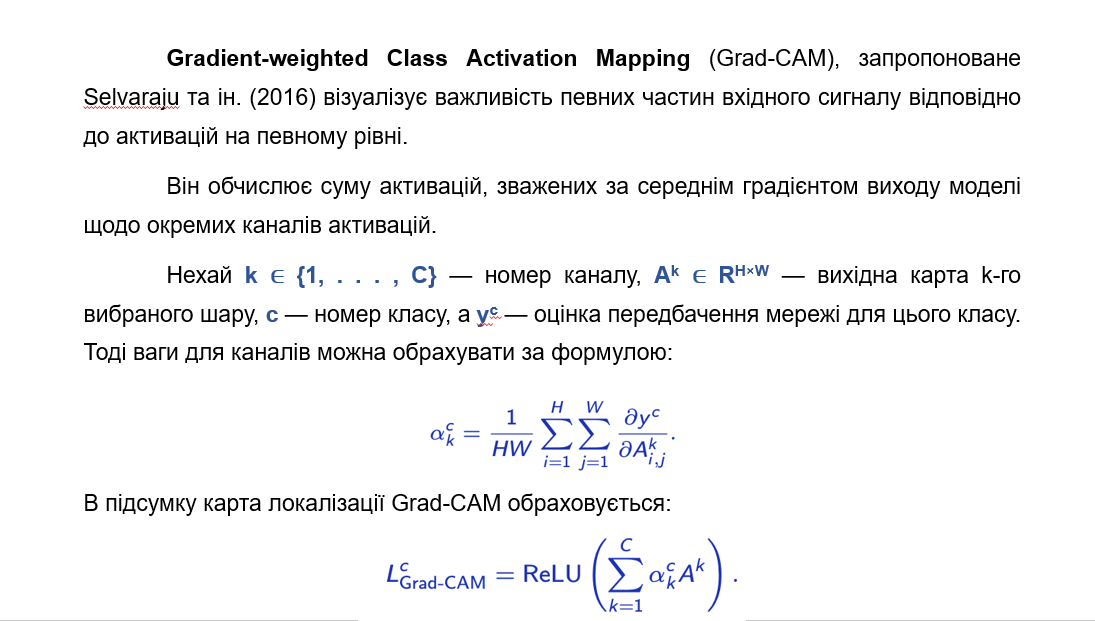

In [ ]:
!pip install grad-cam

In [10]:
print(deep_lab_model)


DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

In [11]:
print(deep_lab_model.decoder.aspp)

Sequential(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPSeparableConv(
        (0): SeparableConv2d(
          (0): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), groups=320, bias=False)
          (1): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPSeparableConv(
        (0): SeparableConv2d(
          (0): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), groups=320, bias=False)
          (1): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.

In [12]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

org_img_pil = Image.fromarray(org_img)
image_tensor = transform(org_img_pil).to(DEVICE)

In [13]:
torch.cuda.empty_cache()

In [14]:
from IPython.display import clear_output
clear_output(wait=True)


In [15]:
# Визначення функцій-хуків для збереження активацій та градієнтів
def hook_store_A(module, input, output):
    """
    Зберігає активації (A) шару під час проходу вперед.

    Аргументи:
    ----------
    module : torch.nn.Module
        Шар моделі, до якого підключається хуком.
    input : Tuple[torch.Tensor]
        Вхідні тензори шару.
    output : torch.Tensor
        Вихідний тензор шару (активації).

    Мета:
    -----
    - Зберегти активації `output` в атрибуті модуля для подальшого використання.
    """
    module.A = output  # Збереження активацій у шарі

def hook_store_dydA(module, grad_input, grad_output):
    """
    Зберігає градієнти (dydA) шару під час проходу назад.

    Аргументи:
    ----------
    module : torch.nn.Module
        Шар моделі, до якого підключається хуком.
    grad_input : Tuple[torch.Tensor]
        Градієнти на вході шару (не використовується).
    grad_output : Tuple[torch.Tensor]
        Градієнти на виході шару.

    Мета:
    -----
    - Зберегти градієнти виходу `grad_output` для подальшого аналізу.
    """
    module.dydA = grad_output[0]  # Збереження градієнтів виходу в атрибуті модуля

# Функція для створення Grad-CAM теплової карти
def generate_gradcam(model, target_layer, image, target_class):
    """
    Генерує теплову карту Grad-CAM для вибраного класу.

    Аргументи:
    ----------
    model : torch.nn.Module
        Модель, для якої генерується теплову карту.
    target_layer : torch.nn.Module
        Шар, активації та градієнти якого використовуються для розрахунку Grad-CAM.
    image : torch.Tensor
        Вхідне зображення у форматі `[C, H, W]` (наприклад, RGB).
    target_class : int
        Індекс цільового класу, для якого будується теплокарта.

    Повертає:
    ---------
    L : np.ndarray
        Теплокарта розміром `[H, W]`, яка показує, які частини зображення
        найбільше впливають на передбачення моделі.

    Покрокове пояснення:
    --------------------
    1. Підготовка зображення: додаємо вимір для батчу (`[1, C, H, W]`) та переносимо на GPU/CPU.
    2. Передбачення: виконуємо forward-прохід через модель.
    3. Цільова метрика: обчислюємо середнє значення активацій для вибраного класу.
    4. Градієнти: обчислюємо градієнти для активацій вибраного шару.
    5. Grad-CAM: поєднуємо градієнти (ваги) з активаціями для створення теплової карти.
    6. Інтерполяція: змінюємо розмір теплової карти до розміру оригінального зображення.
    """
    # 1. Готуємо зображення: додаємо розмір батчу `[C, H, W] -> [1, C, H, W]`
    image = image.unsqueeze(0).to(DEVICE)

    # 2. Передній прохід (forward) через модель
    output = model(image)  # Результат моделі: розмір `[1, num_classes, height, width]`

    # 3. Вибір логітів для цільового класу та їх середнє значення
    target = output[0, target_class, :, :].mean()  # Середнє значення активацій для класу

    # 4. Обчислення градієнтів
    model.zero_grad()  # Очищаємо попередні градієнти
    target.backward()  # Зворотній прохід для обчислення градієнтів

    # 5. Розрахунок Grad-CAM теплової карти
    # 5.1. Усереднюємо градієнти за просторовими вимірами (ваги α)
    alpha = target_layer.dydA.mean((2, 3), keepdim=True)  # Розмір: `[num_filters, 1, 1]`
    # 5.2. Обчислюємо зважену суму активацій (активації помножені на градієнти)
    L = torch.relu((alpha * target_layer.A).sum(1, keepdim=True))  # Розмір: `[1, 1, H, W]`

    # 6. Масштабуємо теплокарту до розміру оригінального зображення
    L = F.interpolate(L, size=(image.size(2), image.size(3)), mode='bilinear', align_corners=False)
    L = L.squeeze().cpu().detach().numpy()

    # 7. Нормалізуємо теплокарту до діапазону [0, 1] для візуалізації
    L = (L - L.min()) / (L.max() - L.min())

    return L  # Повертаємо теплову карту


# Реєстрація хуків
#target_layer_deep_lab = deep_lab_model.decoder.aspp[0].project  # Вибір цільового шару (останній ReLU шару Conv)
target_layer_deep_lab = deep_lab_model.decoder.aspp[0].convs[0][2]


target_layer_deep_lab.register_forward_hook(hook_store_A)  # Хук для збереження активацій
target_layer_deep_lab.register_backward_hook(hook_store_dydA)  # Хук для збереження градієнтів

In [ ]:
target_class = 1  # Наприклад, клас pavement
heatmap_deep_lab = generate_gradcam(deep_lab_model, target_layer_deep_lab, image_tensor, target_class)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(org_img)

plt.subplot(1, 3, 2)
plt.title("Grad-CAM DeepLabV3+")
plt.imshow(heatmap_deep_lab, cmap="jet")
plt.axis("off")

plt.show()

In [ ]:
# Register hooks for FCN
target_layer_fcn = fcn_model.score_fr  # last relu of the conv layers
target_layer_fcn.register_forward_hook(hook_store_A)
target_layer_fcn.register_backward_hook(hook_store_dydA)

heatmap_fcn = generate_gradcam(fcn_model, target_layer_fcn, image_tensor, target_class)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(org_img)

plt.subplot(1, 3, 3)
plt.title("Grad-CAM FCN")
plt.imshow(heatmap_fcn, cmap="jet")
plt.axis("off")

plt.show()

### Навіщо ми робимо всі ці дії?

**Зрозуміти, як модель приймає рішення:**

Grad-CAM дозволяє візуалізувати, які частини зображення найбільше впливають на передбачення моделі для конкретного класу.
Це важливо для інтерпретації моделі, особливо в задачах, де критично розуміти, чому модель приймає певне рішення (наприклад, у медичних чи автономних системах).

**Отримати теплову карту важливих регіонів:**

Grad-CAM будує теплову карту, яка показує, які області зображення є найважливішими для передбачення обраного класу.
Наприклад, якщо модель передбачає клас "дорога", теплокарта покаже, які частини зображення допомогли моделі зробити це передбачення.
Чому потрібні хуки (hook_store_A та hook_store_dydA)?

Збереження активацій (A):

Нам потрібні активації з вибраного шару, щоб визначити просторові особливості, які модель вважає важливими.

Збереження градієнтів (dydA):

Градієнти активацій вказують, наскільки кожен елемент активації впливає на передбачення.
Вони використовуються для зважування активацій, щоб створити теплову карту.
Хуки автоматично зберігають ці значення під час forward та backward проходів моделі.

**Чому ми обираємо останній ReLU шару Conv?**

Останній ReLU шару Conv забезпечує високу просторову роздільну здатність особливостей.
Ці особливості ще не зведені до фінального передбачення, тому вони мають детальні просторові дані, які важливі для локалізації.
Це робить теплову карту точнішою.

**Що ми робимо у функції generate_gradcam?**

Виконуємо передбачення (forward-прохід) для отримання активацій.
Обчислюємо градієнти (backward-прохід) для визначення важливості кожної активації.
Поєднуємо градієнти та активації, щоб створити локалізаційну карту (Grad-CAM).
Масштабуємо теплокарту до розміру оригінального зображення для зручності візуалізації.

**Чому важливий Grad-CAM у реальних застосуваннях?**

Grad-CAM дозволяє виявити проблеми в моделі, наприклад:
Якщо модель неправильно фокусується на нерелевантних областях зображення.
Якщо важливі регіони ігноруються.

# Візуалізація обробки вхідного сигналу


## Оклюзійна чутливість

Ми можемо отримати просту оцінку важливості частини вхідного зображення для даного виходу, обчисливши різницю між:
1. значенням цього виводу на оригінальному зображенні та
2. значенням того самого виходу із закритою частиною на зображенні.

Це обчислювально інтенсивно, оскільки вимагає стільки ж проходів вперед, скільки є місць розташування маски оклюзії, в ідеалі кількість пікселів.


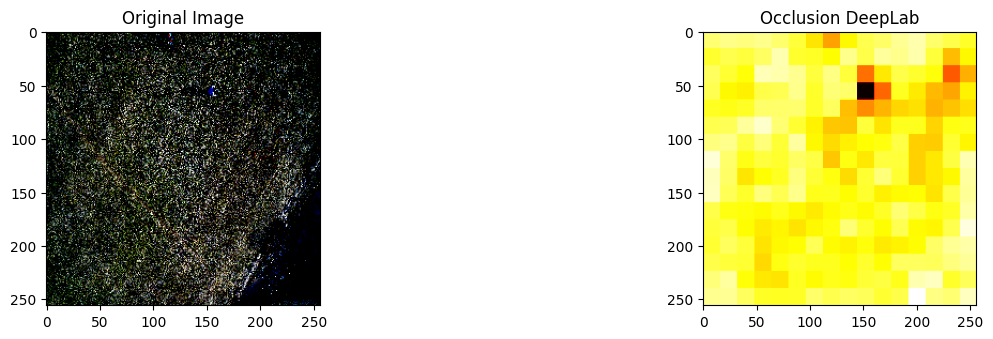

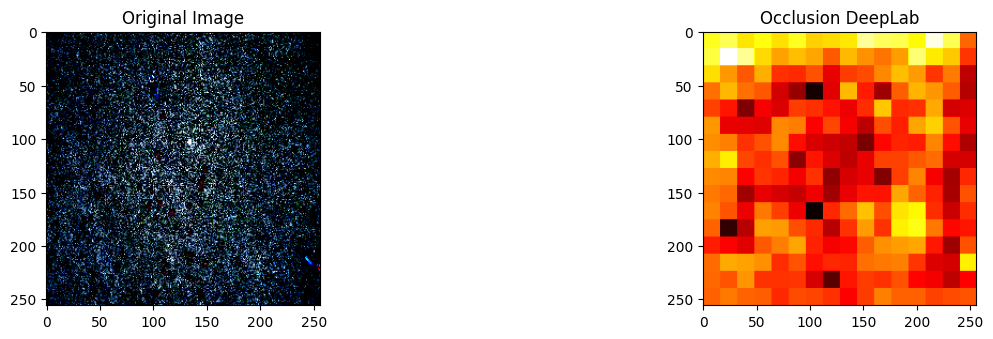

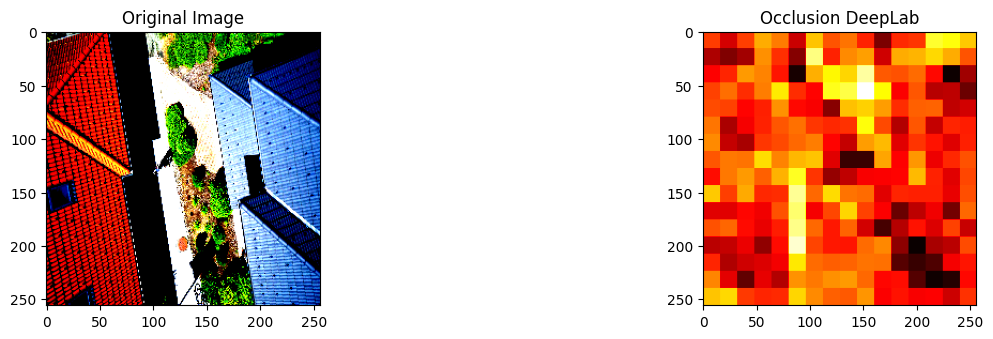

In [ ]:
def occlusion_sensitivity(model, input_image, mask_size=16, class_idx=0):
    """
    Аналіз оклюзійної чутливості для нейронної мережі.

    Ця функція визначає, які частини вхідного зображення найбільше впливають на передбачення моделі.
    Метод базується на обнуленні (оклюзії) частин зображення (маска) та оцінці змін у вихідних значеннях.

    Аргументи:
    ----------
    model : torch.nn.Module
        Модель, для якої проводиться аналіз.
    input_image : torch.Tensor
        Вхідне зображення у форматі `[C, H, W]`, де:
        - C — кількість каналів (наприклад, 3 для RGB),
        - H — висота,
        - W — ширина.
    mask_size : int, optional
        Розмір квадратної маски для оклюзії (за замовчуванням 16).
        Чим менший розмір маски, тим точніше буде теплокарта, але час виконання збільшиться.
    class_idx : int, optional
        Індекс класу, для якого проводиться аналіз (за замовчуванням 0).

    Повертає:
    ---------
    heatmap : np.ndarray
        Теплокарта розміром `[H, W]`, яка відображає чутливість моделі до різних частин зображення.
        - Значення нормалізовані в діапазоні `[0, 1]`.
        - Яскравіші області вказують на високу важливість.

    Ключові моменти:
    ----------------
    - Використовується метод оклюзії: кожна частина зображення тимчасово "закривається",
      і зміна передбачення вимірюється.
    - Виконується нормалізація теплокарти для покращення візуалізації.
    - Функція не змінює параметри моделі завдяки `torch.no_grad()`.

    Алгоритм:
    ---------
    1. Встановлюємо модель у режим оцінки (`model.eval()`), щоб уникнути зміни ваг.
    2. Переводимо вхідне зображення у формат `[1, C, H, W]`, щоб модель приймала його як батч.
    3. Виконуємо початкове передбачення та зберігаємо середнє значення виходу для цільового класу.
    4. Використовуємо цикл для перебору блоків зображення розміром `mask_size x mask_size`:
       - Обнуляємо кожен блок по черзі, створюючи "оклюзоване" зображення.
       - Проводимо передбачення для "оклюзованого" зображення.
       - Різницю між початковим передбаченням і новим значенням записуємо у відповідну ділянку теплокарти.
    5. Нормалізуємо теплокарту для зручності аналізу.
    6. Повертаємо готову теплокарту.

    Код:
    -----
    """

    # 1. Переводимо модель у режим оцінки для збереження ваг (забороняємо оновлення градієнтів).
    model.eval()

    # 2. Додаємо батч-розмір до зображення (з `[C, H, W]` до `[1, C, H, W]`).
    # Це потрібно, оскільки більшість моделей очікують батчі як вхід.
    input_image = input_image.unsqueeze(0).to(DEVICE)

    # 3. Ініціалізуємо теплокарту розміром `[H, W]`, заповнену нулями.
    # Ця карта буде заповнюватись значеннями змін передбачення.
    heatmap = torch.zeros(input_image.shape[2], input_image.shape[3]).to(DEVICE)

    # 4. Виконуємо початкове передбачення без змін у зображенні.
    with torch.no_grad():
        original_output = model(input_image)  # Передбачення для оригінального зображення
        # Беремо середнє значення передбачень для цільового класу (2D вихід для семантичної сегментації).
        original_score = original_output[0, class_idx, :, :].mean().item()

    # 5. Цикл для перебору блоків зображення (оклюзія частинами):
    # Ми пересуваємось по вертикалі (y) та горизонталі (x) з кроком `mask_size`.
    for y in range(0, input_image.shape[2], mask_size):  # Рух по висоті (H)
        for x in range(0, input_image.shape[3], mask_size):  # Рух по ширині (W)
            # 5.1. Створюємо копію вхідного зображення, щоб "закрити" частину.
            occluded_image = input_image.clone()
            # 5.2. Обнуляємо блок пікселів (маску) розміром `mask_size x mask_size`.
            occluded_image[:, :, y:y+mask_size, x:x+mask_size] = 0

            # 5.3. Проводимо передбачення для "оклюзованого" зображення.
            output = model(occluded_image)
            # Беремо середнє значення передбачень для цільового класу.
            score = output[0, class_idx, :, :].mean().item()

            # 5.4. Різницю між початковим і "оклюзованим" передбаченнями записуємо в теплокарту.
            heatmap[y:y+mask_size, x:x+mask_size] = original_score - score

    # 6. Нормалізація теплокарти для приведення значень у діапазон [0, 1].
    # Це необхідно для коректної візуалізації.
    heatmap = heatmap.cpu().numpy()  # Перетворення теплокарти в формат NumPy для візуалізації.
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    return heatmap



for idx, (image, mask) in enumerate(val_loader):
    heatmap_deep_lab = occlusion_sensitivity(deep_lab_model, image[0], class_idx=0)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())

    plt.subplot(1, 3, 3)
    plt.title("Occlusion DeepLab")
    plt.imshow(heatmap_deep_lab, cmap='hot')

    plt.show()

    if idx == 2:
        break


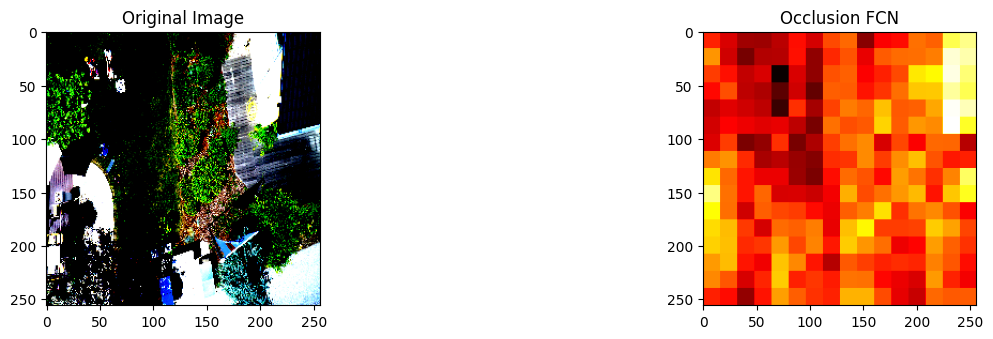

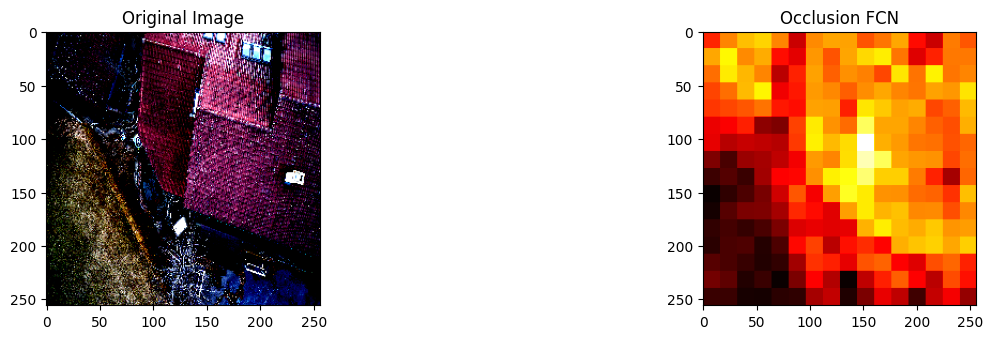

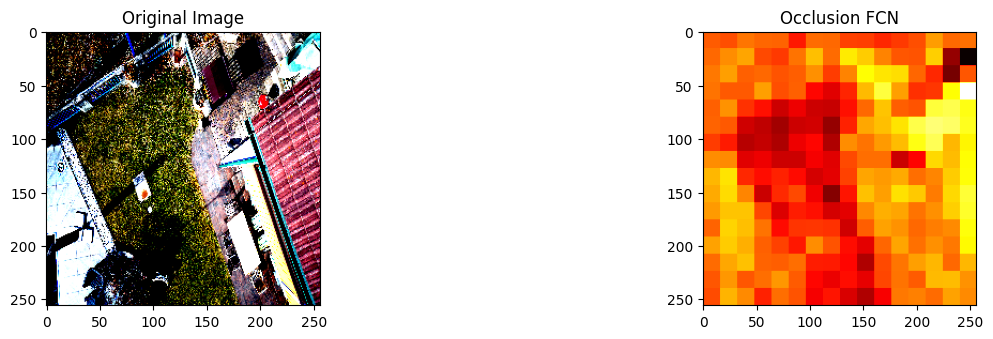

In [ ]:
for idx, (image, mask) in enumerate(val_loader):
    heatmap_fcn = occlusion_sensitivity(fcn_model, image[0], class_idx=0)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())

    plt.subplot(1, 3, 3)
    plt.title("Occlusion FCN")
    plt.imshow(heatmap_fcn, cmap='hot')

    plt.show()

    if idx == 2:
        break

### Oclusion analysis:

**Висновок для FCN:**

Модель FCN краще локалізує важливі частини зображення, зокрема кордони між дахом і іншими елементами сцени.

Вона показує чутливість до різних текстур і забезпечує кращий контекстуальний аналіз.

**Висновок для DeepLab:**

Модель має тенденцію концентрувати увагу лише на найважливіших областях, повністю ігноруючи менш інформативні регіони.

Це підходить для сцен із чітко вираженими об'єктами, але може бути проблемою в сценах із менш вираженими межами чи слабкими текстурами.